# Exchange Index Rates Forecasting

## Problem Statement

This project will be dedicated to the time-series data, particularly, to the exchange index rates. We will analyze the historical data of 3 indices: **American S&P500 or GSPC**, **European EURO STOXX 50 or SX5E** and **Russian Moscow Exchange or MOEX**. Then we will try to predict further prices, fluctuations and so on for a given period, say, 3 months. 

## Data

**American S&P500 or GSPC** : https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC

**European EURO STOXX 50 or SX5E** : https://finance.yahoo.com/quote/SX5E.SW/history?p=SX5E.SW

**Russian Moscow Exchange or MOEX** : https://finance.yahoo.com/quote/IMOEX.ME/history?p=IMOEX.ME

## Project Content

1) Data Import 

2) Exploratory Data Analysis

3) Splitting on the train and test sets

4) Scaling the data

5) Creating X_train and y_train datasets

6) Creating X_test and y_test datasets

7) Creating the RNN for each of 3 indexes

8) Further predictions for the summer 2021

9) Conclusion

## Data Import

In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [2]:
#S&P 500 since 2010
sp500 = pdr.get_data_yahoo("^GSPC", start = "2010-01-01", end = "2021-05-28")
#STOXX for all available on yahoo period
euro = pdr.get_data_yahoo("SX5E.SW", start = "2015-01-22", end = "2021-05-28")
#MOEX for all available on yahoo period
moex = pdr.get_data_yahoo("IMOEX.ME", start = "2013-03-05", end = "2021-05-28")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
#printing the shape of each dataset
print(f"S&P500: {sp500.shape}\nEURO STOXX 50: {euro.shape}\nMOEX: {moex.shape}")

S&P500: (2871, 6)
EURO STOXX 50: (1590, 6)
MOEX: (2026, 6)


In total, we have data for 2871 working days for S&P500, 1590 days for EURO STOXX 50 and 2026 days for MOEX. Let us now see the data structure. Since it is the same across all data, we will check only one of them.

In [4]:
#printing the head
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000


There are 6 columns with Open price - price at the beginning of the day, High - maximum achieved price per day, Low - minimum achieved price per day, Close - price at the end of the day, Adj Close - adjusted close price after all stock splits and dividends are considered and Volume - number of shares traded. Since we are analyzing the indices there is no difference between Close and Adj Close as Indices simply do not pay any dividends, unfortunately. Hence, we will use Close column for predictions. 

In [5]:
#extracting necessary columns
sp_data = sp500.iloc[:, 3:4] #we are interested only in close column and date
euro_data = euro.iloc[:, 3:4]
moex_data = moex.iloc[:, 3:4]

## Exploratory Data Analysis

Before moving to the model creation we will look how the prices have changed throughout the observed period.

In [6]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Year')

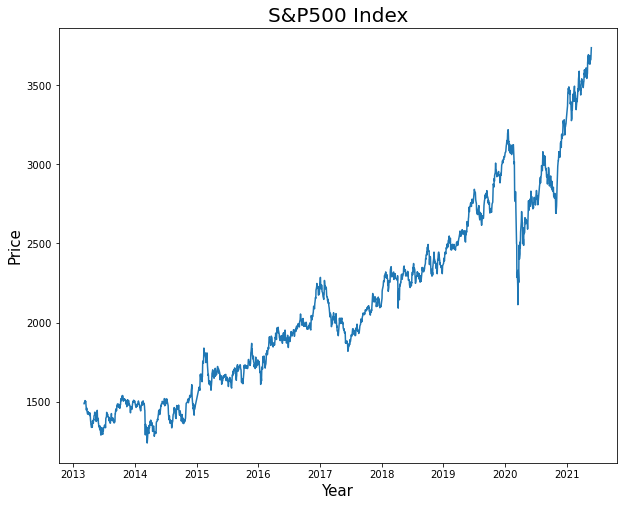

In [7]:
#plot 1
plt.figure(figsize = (10,8))
plt.plot(moex_data)
plt.title("S&P500 Index", fontdict={"fontsize" : 20})
plt.ylabel("Price", fontdict={"fontsize" : 15})
plt.xlabel("Year", fontdict={"fontsize" : 15})

Text(0.5, 0, 'Year')

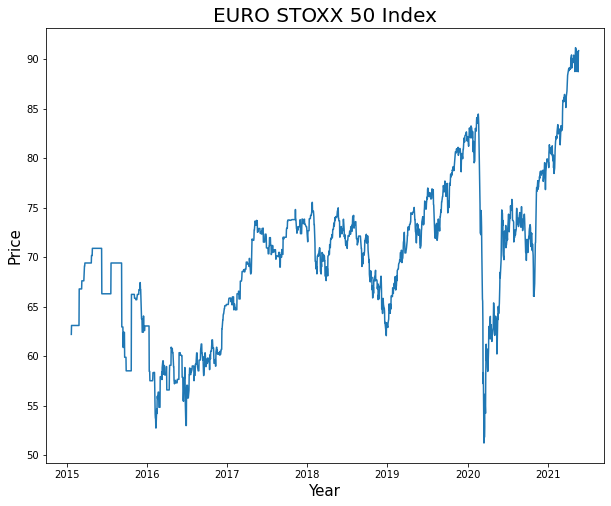

In [8]:
#plot 2
plt.figure(figsize = (10,8))
plt.plot(euro_data)
plt.title("EURO STOXX 50 Index", fontdict={"fontsize" : 20})
plt.ylabel("Price", fontdict={"fontsize" : 15})
plt.xlabel("Year", fontdict={"fontsize" : 15})

Text(0.5, 0, 'Year')

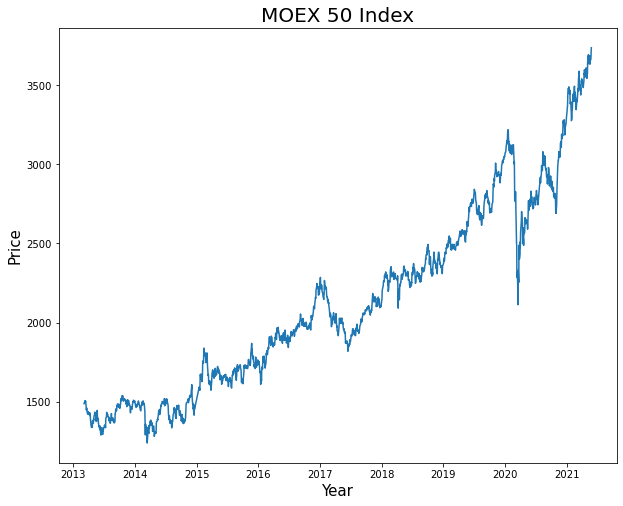

In [9]:
#plot 3
plt.figure(figsize = (10,8))
plt.plot(moex_data)
plt.title("MOEX 50 Index", fontdict={"fontsize" : 20})
plt.ylabel("Price", fontdict={"fontsize" : 15})
plt.xlabel("Year", fontdict={"fontsize" : 15})

MOEX and S&P500 are similar to each other: both are growing in price during the period with a dramatic drop-down in the 2020 which is probably connected with pandemic crisis. Talking about Euro Index, it is more volatile with some valleys in 2016 and, obviously, 2020. 

## Splitting on the train and test sets

Here it is incorrect to use train_test_split method because we are dealing with the time-series data. Hence, we will slice the dataset onto 0.8/0.2 parts.

In [10]:
sp_data_train = sp_data.iloc[:int(sp_data.shape[0]*0.8), : ]
sp_data_test = sp_data.iloc[int(sp_data.shape[0]*0.8) : , : ]

euro_data_train = euro_data.iloc[:int(euro_data.shape[0]*0.8), : ]
euro_data_test = euro_data.iloc[int(euro_data.shape[0]*0.8) : , : ]

moex_data_train = moex_data.iloc[:int(moex_data.shape[0]*0.8), : ]
moex_data_test = moex_data.iloc[int(moex_data.shape[0]*0.8) : , : ]

In [11]:
#printing the shapes of the creted datasets
print(f"S&P500 train: {sp_data_train.shape} and test: {sp_data_test.shape}\nEURO STOXX 50 train: {euro_data_train.shape} and test: {euro_data_test.shape}\nMOEX train: {moex_data_train.shape} and test: {moex_data_test.shape}")
            

S&P500 train: (2296, 1) and test: (575, 1)
EURO STOXX 50 train: (1272, 1) and test: (318, 1)
MOEX train: (1620, 1) and test: (406, 1)


## Scaling the data

For better performance the data will be scaled using MinMaxScaler with range [0, 1].

In [12]:
from sklearn.preprocessing import MinMaxScaler
#instantiate the scaler per each index because the price range is different across the indices
scaler1 = MinMaxScaler(feature_range = (0, 1))
scaler2 = MinMaxScaler(feature_range = (0, 1))
scaler3 = MinMaxScaler(feature_range = (0, 1))

In [13]:
#scaling the data
sp_data_train_scaled = scaler1.fit_transform(sp_data_train)
sp_data_test_scaled = scaler1.transform(sp_data_test)

euro_data_train_scaled = scaler2.fit_transform(euro_data_train)
euro_data_test_scaled = scaler2.transform(euro_data_test)

moex_data_train_scaled = scaler3.fit_transform(moex_data_train)
moex_data_test_scaled = scaler3.transform(moex_data_test)

## Creating X_train and y_train datasets

We will now create the datasets with dependent and independent variables. The price of each day will be predicted based on the data for the previous 150 days. 

In [14]:
#importing basic libraries
import pandas as pd
import numpy as np
#setting the time horizon of 150 days
horizon = 150
X_train_sp = []
y_train_sp = []
for i in range(horizon, len(sp_data_train)):
    #appending for i-th day the data for previous 150 days
    X_train_sp.append(sp_data_train_scaled[i - horizon:i, 0])
    #the price for i-th day
    y_train_sp.append(sp_data_train_scaled[i, 0])

#converting to the numpy arrays
X_train_sp, y_train_sp = np.array(X_train_sp), np.array(y_train_sp)
X_train_sp = np.reshape(X_train_sp, (X_train_sp.shape[0], X_train_sp.shape[1], 1))

In [15]:
#checking the new shapes
print(X_train_sp.shape, y_train_sp.shape)

(2146, 150, 1) (2146,)


In [16]:
#repeating the same for the rest 2 indices

#setting the time horizon of 150 days
horizon = 150
X_train_euro = []
y_train_euro = []
for i in range(horizon, len(euro_data_train)):
    #appending for i-th day the data for previous 150 days
    X_train_euro.append(euro_data_train_scaled[i - horizon:i, 0])
    #the price for i-th day
    y_train_euro.append(euro_data_train_scaled[i, 0])

#converting to the numpy arrays
X_train_euro, y_train_euro = np.array(X_train_euro), np.array(y_train_euro)
X_train_euro = np.reshape(X_train_euro, (X_train_euro.shape[0], X_train_euro.shape[1], 1))

In [17]:
#checking the new shapes
print(X_train_euro.shape, y_train_euro.shape)

(1122, 150, 1) (1122,)


In [18]:
#setting the time horizon of 150 days
horizon = 150
X_train_moex = []
y_train_moex = []
for i in range(horizon, len(moex_data_train)):
    #appending for i-th day the data for previous 150 days
    X_train_moex.append(moex_data_train_scaled[i - horizon:i, 0])
    #the price for i-th day
    y_train_moex.append(moex_data_train_scaled[i, 0])

#converting to the numpy arrays
X_train_moex, y_train_moex = np.array(X_train_moex), np.array(y_train_moex)
X_train_moex = np.reshape(X_train_moex, (X_train_moex.shape[0], X_train_moex.shape[1], 1))

In [19]:
#checking the new shapes
print(X_train_moex.shape, y_train_moex.shape)

(1470, 150, 1) (1470,)


Our train data is ready to be used. Now almost the same procedure will be repeated for the test datasets. the only difference is that we need to take the data for the first 150 days of the testing period as well. We will take them as the last 150 days of the training part. Hence, it is required to use full datasets in order to create test dataset for each index.

## Creating X_test and y_test datasets

In [20]:
#adding to the test part the information for the last 150 days of train part
inputs_sp = sp_data[len(sp_data) - horizon - len(sp_data_test) : ].values
#reshaping the data
inputs_sp = inputs_sp.reshape(-1, 1)
#scaling the data
inputs_sp = scaler1.transform(inputs_sp)

#actual values for the test set
real_stock_price_sp = sp_data_test.values

X_test_sp = []
for i in range(horizon, horizon + len(sp_data_test)):
    X_test_sp.append(inputs_sp[i - horizon: i, 0])

#converting to arrays
X_test_sp = np.array(X_test_sp)
X_test_sp = np.reshape(X_test_sp, (X_test_sp.shape[0], X_test_sp.shape[1], 1))

In [21]:
#checking the shape of the test data
print(X_test_sp.shape)

(575, 150, 1)


In [22]:
#the same for the rest 2 indexes
#adding to the test part the information for the last 150 days of train part
inputs_euro = euro_data[len(euro_data) - horizon - len(euro_data_test) : ].values
#reshaping the data
inputs_euro = inputs_euro.reshape(-1, 1)
#scaling the data
inputs_euro = scaler2.transform(inputs_euro)

#actual values for the test set
real_stock_price_euro = euro_data_test.values

X_test_euro = []
for i in range(horizon, horizon + len(euro_data_test)):
    X_test_euro.append(inputs_euro[i - horizon: i, 0])

#converting to arrays
X_test_euro = np.array(X_test_euro)
X_test_euro = np.reshape(X_test_euro, (X_test_euro.shape[0], X_test_euro.shape[1], 1))

In [23]:
#checking the shape of the test data
print(X_test_euro.shape)

(318, 150, 1)


In [24]:
#adding to the test part the information for the last 150 days of train part
inputs_moex = moex_data[len(moex_data) - horizon - len(moex_data_test) : ].values
#reshaping the data
inputs_moex = inputs_moex.reshape(-1, 1)
#scaling the data
inputs_moex = scaler3.transform(inputs_moex)

#actual values for the test set
real_stock_price_moex = moex_data_test.values

X_test_moex = []
for i in range(horizon, horizon + len(moex_data_test)):
    X_test_moex.append(inputs_moex[i - horizon: i, 0])

#converting to arrays
X_test_moex = np.array(X_test_moex)
X_test_moex = np.reshape(X_test_moex, (X_test_moex.shape[0], X_test_moex.shape[1], 1))

In [25]:
#checking the shape of the test data
print(X_test_moex.shape)

(406, 150, 1)


Finally, both train and test datasets are ready to be used by the model. We will be using Recurrent Neural Network or RNN that can perform well on the time-series data due to its Long-Short-Term-Memory approach.

## Creating the RNN

### S&P500

In [26]:
import tensorflow as tf

In [27]:
#importing libraries and objects
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LSTM

In [35]:
#building the model 1
model1 = Sequential()

model1.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_sp.shape[1], 1)))
model1.add(BatchNormalization())

model1.add(LSTM(units = 64, return_sequences = True))
model1.add(BatchNormalization())

model1.add(LSTM(units = 64, return_sequences = True))
model1.add(BatchNormalization())

model1.add(LSTM(units = 64, return_sequences = False))
model1.add(BatchNormalization())

model1.add(Dense(units = 1))

In [36]:
#providing the summary of the model
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 150, 64)           16896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 64)           256       
_________________________________________________________________
lstm_5 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 64)           256       
_________________________________________________________________
lstm_6 (LSTM)                (None, 150, 64)           33024     
_________________________________________________________________
batch_normalization_6 (Batch (None, 150, 64)           256       
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)               

In [67]:
#importing the callback
from keras.callbacks import EarlyStopping
stop = EarlyStopping(patience = 15, restore_best_weights = True) # stop if there are 15 epochs with no improvements

In [68]:
#compiling the model
model1.compile(optimizer = 'adam', loss = ["mean_squared_error"], metrics = ["mae", "mse"])

In [69]:
#fitting the model
model1.fit(X_train_sp, y_train_sp,
           validation_data = (X_test_sp, scaler1.transform(real_stock_price_sp)),
           batch_size = 32,
           epochs = 100, 
           callbacks = [stop])

Epoch 1/100
68/68 [==============================] - 21s 221ms/step - loss: 0.0034 - mae: 0.0471 - mse: 0.0034 - val_loss: 0.0081 - val_mae: 0.0764 - val_mse: 0.0081
Epoch 2/100
68/68 [==============================] - 13s 188ms/step - loss: 0.0031 - mae: 0.0431 - mse: 0.0031 - val_loss: 0.0047 - val_mae: 0.0497 - val_mse: 0.0047
Epoch 3/100
68/68 [==============================] - 13s 184ms/step - loss: 0.0041 - mae: 0.0505 - mse: 0.0041 - val_loss: 0.0335 - val_mae: 0.1673 - val_mse: 0.0335
Epoch 4/100
68/68 [==============================] - 12s 183ms/step - loss: 0.0087 - mae: 0.0728 - mse: 0.0087 - val_loss: 0.5002 - val_mae: 0.6623 - val_mse: 0.5002
Epoch 5/100
68/68 [==============================] - 12s 184ms/step - loss: 0.0041 - mae: 0.0513 - mse: 0.0041 - val_loss: 0.1969 - val_mae: 0.4201 - val_mse: 0.1969
Epoch 6/100
68/68 [==============================] - 13s 185ms/step - loss: 0.0040 - mae: 0.0495 - mse: 0.0040 - val_loss: 0.1807 - val_mae: 0.3176 - val_mse: 0.1807
Epoc

In [70]:
#make the predictions and inverse them as they were scaled
predictions_sp = scaler1.inverse_transform(model1.predict(X_test_sp))

In [71]:
#importing metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [72]:
#checking MAE
mean_absolute_error(scaler1.inverse_transform(model1.predict(X_test_sp)), real_stock_price_sp)

94.74802394701086

In [75]:
#adding the predictions as a new column in the test data
import warnings
warnings.filterwarnings('ignore')
sp_data_test["prediction"] = predictions_sp

<function matplotlib.pyplot.show(close=None, block=None)>

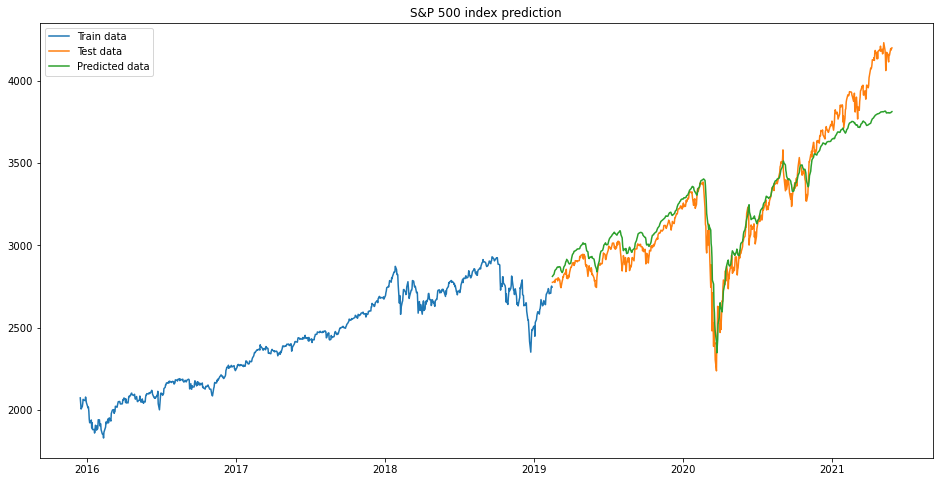

In [81]:
#plotting the result
plt.figure(figsize = (16,8))
plt.plot(sp_data_train['Close'][1500:])
plt.plot(sp_data_test['Close'])
plt.plot(sp_data_test['prediction'])
plt.legend(['Train data', 'Test data', 'Predicted data'])
plt.title("S&P 500 index prediction")
plt.show

In [101]:
#one can also see the ratio of MAE to mean value of the close price
mean_absolute_error(scaler1.inverse_transform(model1.predict(X_test_sp)), real_stock_price_sp) / sp_data.mean()

Close    0.044195
dtype: float64

In [103]:
#the ratio of RMSE and close price
mean_squared_error(scaler1.inverse_transform(model1.predict(X_test_sp)), real_stock_price_sp, squared = False) / sp_data.mean()

Close    0.061019
dtype: float64

The graph above shows the quality of the prediction. Predicted data repeat the fluctuations of the test data almost everywhere. The only more or less significant difference can be seen at the end of the observable period. Nevertheless, total performance of the model can be estimated as good. Moreover, in accordance with MAE/Close mean price and RMSE/Close mean price one can say that in average the prediction is biased only on 4-6%.

### EURO STOXX 50

In [82]:
#building the model 2
model2 = Sequential()

model2.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_sp.shape[1], 1)))
model2.add(BatchNormalization())

model2.add(LSTM(units = 64, return_sequences = True))
model2.add(BatchNormalization())

model2.add(LSTM(units = 64, return_sequences = True))
model2.add(BatchNormalization())

model2.add(LSTM(units = 64, return_sequences = False))
model2.add(BatchNormalization())

model2.add(Dense(units = 1))

In [83]:
stop2 = EarlyStopping(patience = 15, restore_best_weights = True) # stop if there are 15 epochs with no improvements

In [84]:
#compiling the model
model2.compile(optimizer = 'adam', loss = ["mean_squared_error"], metrics = ["mae", "mse"])

In [86]:
#fitting the model
model2.fit(X_train_euro, y_train_euro,
           validation_data = (X_test_euro, scaler2.transform(real_stock_price_euro)),
           batch_size = 32,
           epochs = 100, 
           callbacks = [stop2])

Epoch 1/100
36/36 [==============================] - 9s 238ms/step - loss: 0.0244 - mae: 0.1231 - mse: 0.0244 - val_loss: 0.0482 - val_mae: 0.1671 - val_mse: 0.0482
Epoch 2/100
36/36 [==============================] - 8s 230ms/step - loss: 0.0131 - mae: 0.0883 - mse: 0.0131 - val_loss: 0.0484 - val_mae: 0.1631 - val_mse: 0.0484
Epoch 3/100
36/36 [==============================] - 7s 191ms/step - loss: 0.0112 - mae: 0.0761 - mse: 0.0112 - val_loss: 0.1295 - val_mae: 0.3184 - val_mse: 0.1295
Epoch 4/100
36/36 [==============================] - 7s 187ms/step - loss: 0.0559 - mae: 0.1765 - mse: 0.0559 - val_loss: 0.0593 - val_mae: 0.1914 - val_mse: 0.0593
Epoch 5/100
36/36 [==============================] - 7s 184ms/step - loss: 0.0254 - mae: 0.1187 - mse: 0.0254 - val_loss: 0.0471 - val_mae: 0.1661 - val_mse: 0.0471
Epoch 6/100
36/36 [==============================] - 7s 184ms/step - loss: 0.0076 - mae: 0.0666 - mse: 0.0076 - val_loss: 0.0475 - val_mae: 0.1753 - val_mse: 0.0475
Epoch 7/10

In [87]:
#make the predictions and inverse them as they were scaled
predictions_euro = scaler2.inverse_transform(model2.predict(X_test_euro))

In [88]:
#checking MAE
mean_absolute_error(predictions_euro, real_stock_price_euro)

2.9266849013994323

In [89]:
#adding a new column with predictions so that the days are coincided(easier to plot then)
euro_data_test["prediction"] = predictions_euro

<function matplotlib.pyplot.show(close=None, block=None)>

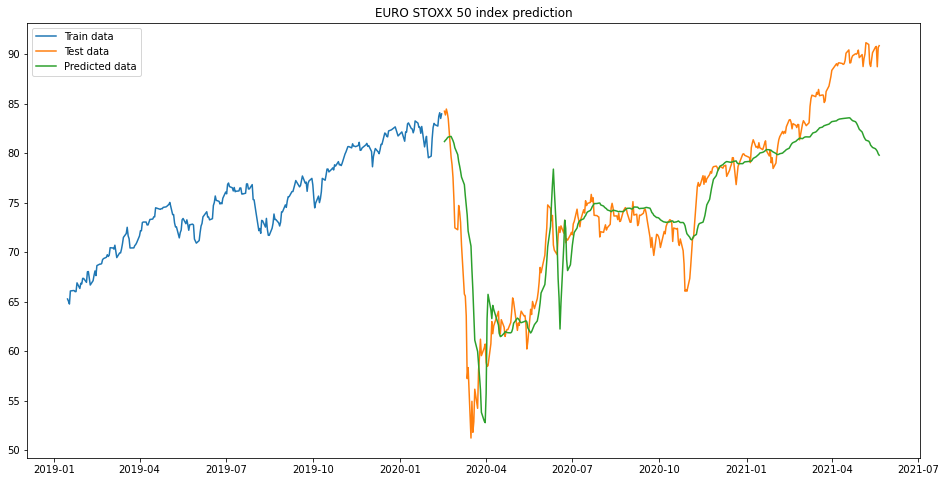

In [91]:
#plotting the result
plt.figure(figsize = (16,8))
plt.plot(euro_data_train['Close'][1000:])
plt.plot(euro_data_test['Close'])
plt.plot(euro_data_test['prediction'])
plt.legend(['Train data', 'Test data', 'Predicted data'])
plt.title("EURO STOXX 50 index prediction")
plt.show

In [105]:
#one can also see the ratio of MAE to mean value of the close price
mean_absolute_error(scaler2.inverse_transform(model2.predict(X_test_euro)), real_stock_price_euro) / euro_data.mean()

Close    0.041915
dtype: float64

In [106]:
#the ratio of RMSE and close price
mean_squared_error(scaler2.inverse_transform(model2.predict(X_test_euro)), real_stock_price_euro, squared = False) / euro_data.mean()

Close    0.060492
dtype: float64

In case of Euro Exchange Index the situation is similar to the previous one. RNN performs extremely well, repeating all the picks and valleys of the original data. The only thing that was not cought can be seen at the end of the period. Considering the ratios of MAE and RMSE to the mean value of the index price, the result is almost the same as for S&P500. Both are doing well.

## MOEX

In [93]:
#building the model 3
model3 = Sequential()

model3.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_sp.shape[1], 1)))
model3.add(BatchNormalization())

model3.add(LSTM(units = 64, return_sequences = True))
model3.add(BatchNormalization())

model3.add(LSTM(units = 64, return_sequences = True))
model3.add(BatchNormalization())

model3.add(LSTM(units = 64, return_sequences = False))
model3.add(BatchNormalization())

model3.add(Dense(units = 1))

In [94]:
#compiling the model
model3.compile(optimizer = 'adam', loss = ["mean_squared_error"], metrics = ["mae", "mse"])

In [95]:
#fitting the model
model3.fit(X_train_moex, y_train_moex,
           validation_data = (X_test_moex, scaler3.transform(real_stock_price_moex)),
           batch_size = 32,
           epochs = 100, 
           callbacks = [stop2])

Epoch 1/100
46/46 [==============================] - 20s 251ms/step - loss: 0.6900 - mae: 0.5918 - mse: 0.6900 - val_loss: 0.6754 - val_mae: 0.7966 - val_mse: 0.6754
Epoch 2/100
46/46 [==============================] - 10s 209ms/step - loss: 0.0195 - mae: 0.1091 - mse: 0.0195 - val_loss: 0.5552 - val_mae: 0.7206 - val_mse: 0.5552
Epoch 3/100
46/46 [==============================] - 10s 215ms/step - loss: 0.0089 - mae: 0.0728 - mse: 0.0089 - val_loss: 0.5181 - val_mae: 0.6935 - val_mse: 0.5181
Epoch 4/100
46/46 [==============================] - 10s 226ms/step - loss: 0.0081 - mae: 0.0715 - mse: 0.0081 - val_loss: 0.4682 - val_mae: 0.6525 - val_mse: 0.4682
Epoch 5/100
46/46 [==============================] - 10s 215ms/step - loss: 0.0056 - mae: 0.0600 - mse: 0.0056 - val_loss: 0.4419 - val_mae: 0.6351 - val_mse: 0.4419
Epoch 6/100
46/46 [==============================] - 11s 236ms/step - loss: 0.0046 - mae: 0.0545 - mse: 0.0046 - val_loss: 0.3874 - val_mae: 0.5969 - val_mse: 0.3874
Epoc

In [96]:
#make the predictions and inverse them as they were scaled
predictions_moex = scaler3.inverse_transform(model3.predict(X_test_moex))

In [97]:
#checking MAE
mean_absolute_error(predictions_moex, real_stock_price_moex)

68.66310878810037

In [98]:
#adding a new column with predictions so that the days are coincided(easier to plot then)
moex_data_test["prediction"] = predictions_moex

<function matplotlib.pyplot.show(close=None, block=None)>

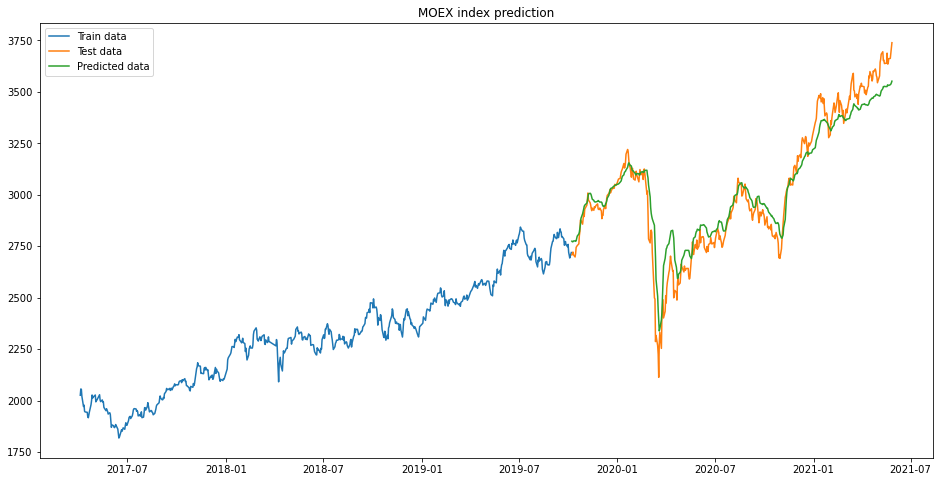

In [99]:
#plotting the result
plt.figure(figsize = (16,8))
plt.plot(moex_data_train['Close'][1000:])
plt.plot(moex_data_test['Close'])
plt.plot(moex_data_test['prediction'])
plt.legend(['Train data', 'Test data', 'Predicted data'])
plt.title("MOEX index prediction")
plt.show

In [107]:
#one can also see the ratio of MAE to mean value of the close price
mean_absolute_error(scaler3.inverse_transform(model3.predict(X_test_moex)), real_stock_price_moex) / moex_data.mean()


Close    0.032122
dtype: float64

In [108]:
#the ratio of RMSE and close price
mean_squared_error(scaler3.inverse_transform(model3.predict(X_test_moex)), real_stock_price_moex, squared = False) / moex_data.mean()

Close    0.042513
dtype: float64

The model shows the best results for the MOEX index among all indices. It repeats all fluctuations of the real data. Moreover, the RMSE and MAE ratios are significantly lower than those of EURO STOXX 50 and S&P500. 

## Further Predictions

Once the model are trained and evaluated, we can predict the index prices for future period. In particular, we will be **predicting the price** of the indices for **the summer 2021.** However, in order to plot the predictions together with the existing data correctly, we need to create the dataframe with the predictions and date column. Moreover, this date column should include only working days as the exchange is not operating during the weekends.

## S&P500

In [204]:
sp_predictions_summer = pd.DataFrame()
#making the list of working days from today till 1st of September
sp_predictions_summer["days"] = pd.bdate_range(start = '2021-05-29', end = '2021-09-01')

Now we will create the same X dataset for the predictions as in the previous procedures.

In [205]:
#taking the information for the 150 + 68 days(number of summer working days)
inputs_sp_summer = sp_data[len(sp_data) - horizon - len(sp_predictions_summer):].values

In [206]:
#reshaping and scaling
inputs_sp_summer = inputs_sp_summer.reshape(-1, 1)
inputs_sp_summer = scaler1.transform(inputs_sp_summer)

In [207]:
X_sp_summer = []
for i in range(horizon, horizon + len(sp_predictions_summer)):
    X_sp_summer.append(inputs_sp_summer[i - horizon: i, 0])
    
X_sp_summer = np.array(X_sp_summer)
X_sp_summer = np.reshape(X_sp_summer, (X_sp_summer.shape[0], X_sp_summer.shape[1], 1))

In [208]:
#checking the shape of the data
X_sp_summer.shape

(68, 150, 1)

In [209]:
#making the predictions
sp_summer_pred = scaler1.inverse_transform(model1.predict(X_sp_summer))
#adding them to the dataframe
sp_predictions_summer["prediction"] = sp_summer_pred

In [210]:
#modifying the dataframe
sp_predictions_summer.set_index("days", inplace = True)
sp_predictions_summer.head()

,prediction
days,
2021-05-31,3751.786865
2021-06-01,3747.117920
2021-06-02,3743.802734
2021-06-03,3745.847168
2021-06-04,3737.915283


In [211]:
#concatenating the predictions for further visualization
sp_test_final = np.concatenate((X_test_sp, X_sp_summer), axis = 0)

In [212]:
#scaling them
sp_final_pred = scaler1.inverse_transform(model1.predict(sp_test_final))

In [213]:
df = pd.DataFrame()
df["days"] = np.concatenate((sp_data_test.index, pd.bdate_range(start = '2021-05-29', end = '2021-09-01')),
                            axis = 0)
df['predictions'] = sp_final_pred
df.set_index("days", inplace = True)
df.head()

,predictions
days,
2019-02-15,2811.752930
2019-02-19,2825.229248
2019-02-20,2836.552002
2019-02-21,2846.491943
2019-02-22,2850.229004


<function matplotlib.pyplot.show(close=None, block=None)>

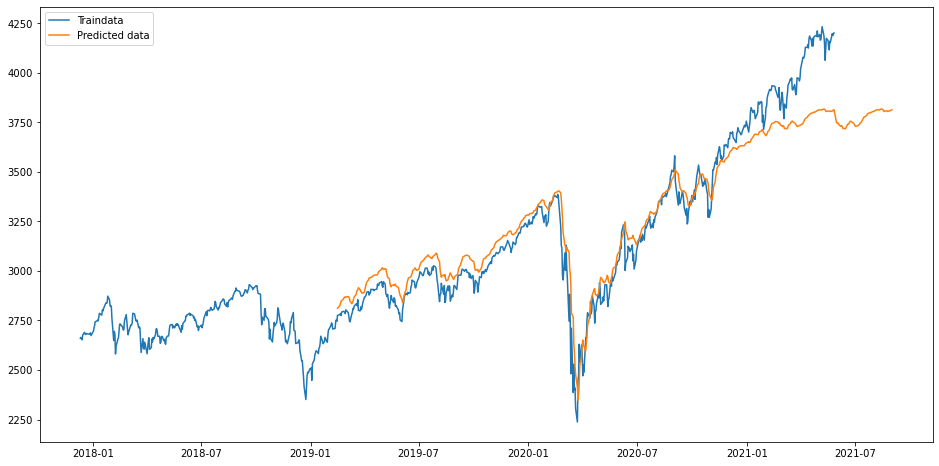

In [214]:
#plotting the result
plt.figure(figsize = (16,8))
plt.plot(sp_data['Close'][2000:])
plt.plot(df["predictions"])
plt.legend(['Traindata', 'Predicted data'])
plt.show

As a final result we will compute the total predicted return for the index as (Price at the last summer day - Price at the first summer day)/Price at the first summer day.

In [215]:
sp_return = (df[df.index == '2021-09-01']["predictions"][0]  - df[df.index == '2021-06-01']["predictions"][0])/df[df.index == '2021-06-01']["predictions"][0]
sp_return = (sp_return * 100).round(2)
print(f"Predicted S&P500 return for the summer 2021: {sp_return}%")


Predicted S&P500 return for the summer 2021: 1.77%


Now we will repeat the same procedure for MOEX and EURO STOXX 50.

<function matplotlib.pyplot.show(close=None, block=None)>

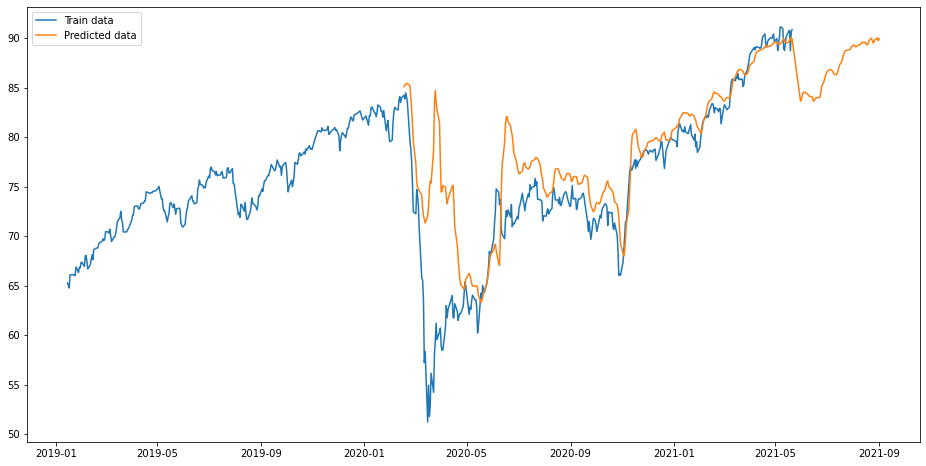

In [216]:
euro_predictions_summer = pd.DataFrame()
#making the list of working days from today till 1st of September
euro_predictions_summer["days"] = pd.bdate_range(start = '2021-05-29', end = '2021-09-01')


inputs_euro_summer = euro_data[len(euro_data) - horizon - len(euro_predictions_summer):].values

inputs_euro_summer = inputs_euro_summer.reshape(-1, 1)
inputs_euro_summer = scaler2.transform(inputs_euro_summer)

X_euro_summer = []
for i in range(horizon, horizon + len(euro_predictions_summer)):
    X_euro_summer.append(inputs_euro_summer[i - horizon: i, 0])
    
X_euro_summer = np.array(X_euro_summer)
X_euro_summer = np.reshape(X_euro_summer, (X_euro_summer.shape[0], X_euro_summer.shape[1], 1))

#checking the shape of the data
X_euro_summer.shape

#making the predictions
euro_summer_pred = scaler2.inverse_transform(model3.predict(X_euro_summer))
#adding them to the dataframe
euro_predictions_summer["prediction"] = euro_summer_pred

#modifying the dataframe
euro_predictions_summer.set_index("days", inplace = True)
euro_predictions_summer.head()


euro_test_final = np.concatenate((X_test_euro, X_euro_summer), axis = 0)

euro_final_pred = scaler2.inverse_transform(model3.predict(euro_test_final))

df = pd.DataFrame()
df["days"] = np.concatenate((euro_data_test.index, pd.bdate_range(start = '2021-05-29', end = '2021-09-01')),
                            axis = 0)
df['predictions'] = euro_final_pred
df.set_index("days", inplace = True)
df.head()

#plotting the result
plt.figure(figsize = (16,8))
plt.plot(euro_data['Close'][1000:])
plt.plot(df["predictions"])
plt.legend(['Train data', 'Predicted data'])
plt.show

In [217]:
euro_return = (df[df.index == '2021-09-01']["predictions"][0]  - df[df.index == '2021-06-01']["predictions"][0])/df[df.index == '2021-06-01']["predictions"][0]
euro_return = (euro_return * 100).round(2)
print(f"Predicted EURO STOXX 50 return for the summer 2021: {euro_return}%")


Predicted EURO STOXX 50 return for the summer 2021: 7.25%


<function matplotlib.pyplot.show(close=None, block=None)>

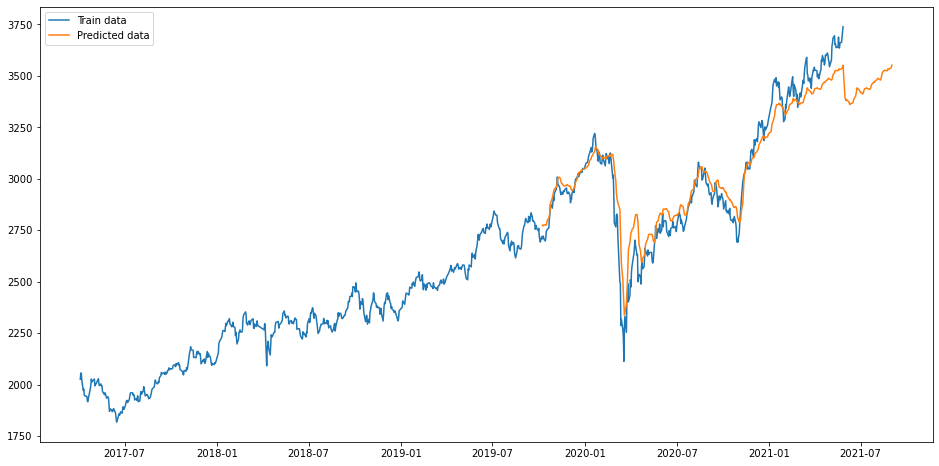

In [218]:
moex_predictions_summer = pd.DataFrame()
#making the list of working days from today till 1st of September
moex_predictions_summer["days"] = pd.bdate_range(start = '2021-05-29', end = '2021-09-01')


inputs_moex_summer = moex_data[len(moex_data) - horizon - len(moex_predictions_summer):].values

inputs_moex_summer = inputs_moex_summer.reshape(-1, 1)
inputs_moex_summer = scaler3.transform(inputs_moex_summer)

X_moex_summer = []
for i in range(horizon, horizon + len(moex_predictions_summer)):
    X_moex_summer.append(inputs_moex_summer[i - horizon: i, 0])
    
X_moex_summer = np.array(X_moex_summer)
X_moex_summer = np.reshape(X_moex_summer, (X_moex_summer.shape[0], X_moex_summer.shape[1], 1))

#checking the shape of the data
X_moex_summer.shape

#making the predictions
moex_summer_pred = scaler3.inverse_transform(model3.predict(X_moex_summer))
#adding them to the dataframe
moex_predictions_summer["prediction"] = moex_summer_pred

#modifying the dataframe
moex_predictions_summer.set_index("days", inplace = True)
moex_predictions_summer.head()


moex_test_final = np.concatenate((X_test_moex, X_moex_summer), axis = 0)

moex_final_pred = scaler3.inverse_transform(model3.predict(moex_test_final))

df = pd.DataFrame()
df["days"] = np.concatenate((moex_data_test.index, pd.bdate_range(start = '2021-05-29', end = '2021-09-01')),
                            axis = 0)
df['predictions'] = moex_final_pred
df.set_index("days", inplace = True)
df.head()

#plotting the result
plt.figure(figsize = (16,8))
plt.plot(moex_data['Close'][1000:])
plt.plot(df["predictions"])
plt.legend(['Train data', 'Predicted data'])
plt.show

In [219]:
moex_return = (df[df.index == '2021-09-01']["predictions"][0]  - df[df.index == '2021-06-01']["predictions"][0])/df[df.index == '2021-06-01']["predictions"][0]
moex_return = (moex_return * 100).round(2)
print(f"Predicted MOEX return for the summer 2021: {moex_return}%")


Predicted MOEX return for the summer 2021: 4.87%


## Conclusion

We analyzed 3 indexes: S&P500, EURO STOXX 50 and MOEX. Recurrent Neural Network was constructed for the predictions. Overall, it performs well despite it does not catch all fluctuations at the end of the period. However, in average, predictions are overestimated or underestimated from their original value only on 3-6%. Talking about the final predictions, the model claims that during the summer 2021 American index will raise up for 1.77%, European for 7.25% and Russian for 4.87%. The result seems to be realistic. However, in this project we predict values based on the previous 150 days. This period may be increased as well as number of layers of the Network. 